In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install necessary libraries
!pip install tensorflow
!pip install keras
!pip install scikit-learn

In [ ]:
# Import libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import os
import matplotlib.pyplot as plt

In [ ]:
# Define dataset paths
data_path = '/content/drive/MyDrive/Dataset/Alzheimers-ADNI'
train_path = os.path.join(data_path, 'train')
test_path = os.path.join(data_path, 'test')

# Define image dimensions and batch size
img_size = (224, 224)
batch_size = 32

In [ ]:
# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Validation set without data augmentation
valid_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Load the training set
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Load the validation set
valid_generator = valid_datagen.flow_from_directory(
    test_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)


Found 1101 images belonging to 5 classes.
Found 195 images belonging to 5 classes.


In [ ]:
# Define InceptionV3 with Transfer Learning
base_model_incep = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model_incep = models.Sequential()
model_incep.add(base_model_incep)
model_incep.add(layers.GlobalAveragePooling2D())
model_incep.add(layers.Dense(5, activation='softmax'))

# Freeze base model layers
for layer in base_model_incep.layers:
    layer.trainable = False

87910968/87910968 [==============================] - 4s 0us/step


In [ ]:
# Fine-tune the model
for layer in base_model_incep.layers:
    layer.trainable = True

# Compile the model for fine-tuning
model_incep.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with Fine-Tuning
epochs_fine_tuning = 5
history_fine_tuning = model_incep.fit(train_generator, epochs=epochs_fine_tuning, validation_data=valid_generator)

Epoch 1/5
35/35 [==============================] - 851s 23s/step - loss: 1.4557 - accuracy: 0.4342 - val_loss: 108.1243 - val_accuracy: 0.1795
Epoch 2/5
35/35 [==============================] - 19s 544ms/step - loss: 1.3813 - accuracy: 0.4550 - val_loss: 10.4209 - val_accuracy: 0.2974
Epoch 3/5
35/35 [==============================] - 20s 569ms/step - loss: 1.3795 - accuracy: 0.4650 - val_loss: 4.1783 - val_accuracy: 0.4667
Epoch 4/5
35/35 [==============================] - 19s 541ms/step - loss: 1.3435 - accuracy: 0.4578 - val_loss: 4.1996 - val_accuracy: 0.2205
Epoch 5/5
35/35 [==============================] - 20s 582ms/step - loss: 1.3296 - accuracy: 0.4714 - val_loss: 1.5171 - val_accuracy: 0.4103


In [ ]:
# Compile the model
model_incep.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with Transfer Learning
epochs_transfer_learning = 10
history_transfer_learning = model_incep.fit(train_generator, epochs=epochs_transfer_learning, validation_data=valid_generator)


Epoch 1/10
35/35 [==============================] - 51s 591ms/step - loss: 1.4110 - accuracy: 0.4550 - val_loss: 20.4191 - val_accuracy: 0.1333
Epoch 2/10
35/35 [==============================] - 20s 572ms/step - loss: 1.3503 - accuracy: 0.4741 - val_loss: 19.5885 - val_accuracy: 0.4564
Epoch 3/10
35/35 [==============================] - 20s 567ms/step - loss: 1.3681 - accuracy: 0.4587 - val_loss: 12.7062 - val_accuracy: 0.4359
Epoch 4/10
35/35 [==============================] - 21s 599ms/step - loss: 1.3748 - accuracy: 0.4687 - val_loss: 10.0988 - val_accuracy: 0.1385
Epoch 5/10
35/35 [==============================] - 22s 619ms/step - loss: 1.3683 - accuracy: 0.4559 - val_loss: 85.6384 - val_accuracy: 0.4513
Epoch 6/10
35/35 [==============================] - 21s 607ms/step - loss: 1.3491 - accuracy: 0.4605 - val_loss: 6.9392 - val_accuracy: 0.1538
Epoch 7/10
35/35 [==============================] - 20s 577ms/step - loss: 1.3045 - accuracy: 0.4614 - val_loss: 1.6557 - val_accuracy: 0

In [ ]:
# Save the model
model_incep.save('/content/drive/MyDrive/inceptionv3_transfer_fine_tuning.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Evaluate the model on test set
test_generator = valid_datagen.flow_from_directory(
    test_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Important: set shuffle to False for correct evaluation
)

Found 195 images belonging to 5 classes.


In [ ]:
# Evaluate the model
eval_results = model_incep.evaluate(test_generator)
print("Test Accuracy:", eval_results[1])

7/7 [==============================] - 1s 119ms/step - loss: 1.4333 - accuracy: 0.4256
Test Accuracy: 0.4256410300731659


In [ ]:
# Get predictions
predictions = model_incep.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

7/7 [==============================] - 2s 124ms/step


In [ ]:
# Print classification report
print("Classification Report:")
print(classification_report(true_classes, predicted_classes))


Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.19      0.28        26
           1       0.46      0.86      0.60        87
           2       0.17      0.08      0.11        36
           3       0.00      0.00      0.00        11
           4       0.00      0.00      0.00        35

    accuracy                           0.43       195
   macro avg       0.23      0.23      0.20       195
weighted avg       0.30      0.43      0.33       195



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(true_classes, predicted_classes))


Confusion Matrix:
[[ 5 19  1  1  0]
 [ 3 75  8  1  0]
 [ 0 32  3  1  0]
 [ 1  9  1  0  0]
 [ 1 28  5  1  0]]


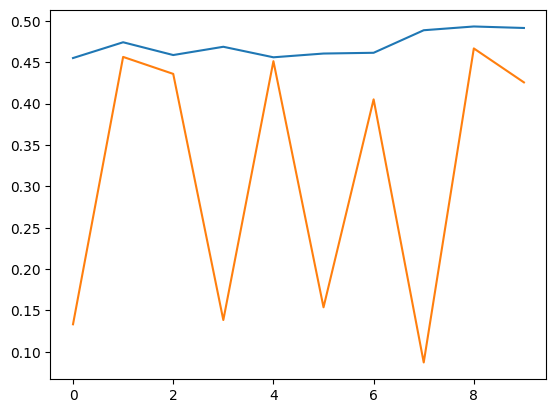

In [ ]:
# Plot training and validation accuracy vs epochs for Transfer Learning
plt.plot(history_transfer_learning.history['accuracy'], label='Training Accuracy (Transfer Learning)')
plt.plot(history_transfer_learning.history['val_accuracy'], label='Validation Accuracy (Transfer Learning)')


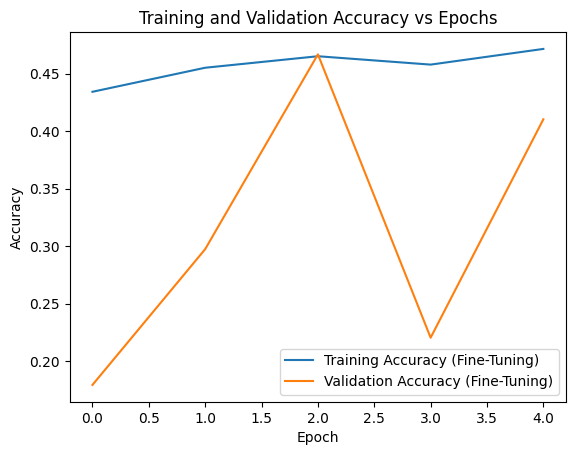

In [ ]:
# Plot training and validation accuracy vs epochs for Fine-Tuning
plt.plot(history_fine_tuning.history['accuracy'], label='Training Accuracy (Fine-Tuning)')
plt.plot(history_fine_tuning.history['val_accuracy'], label='Validation Accuracy (Fine-Tuning)')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy vs Epochs')
plt.show()


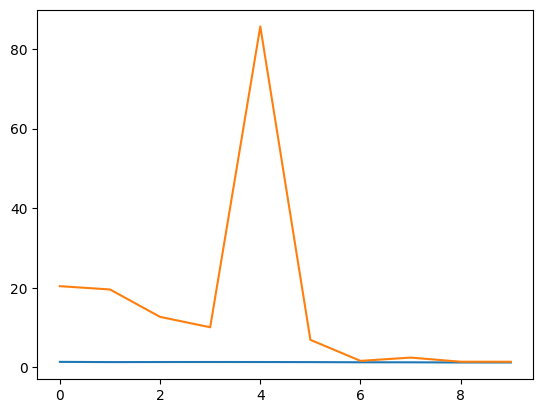

In [ ]:
# Plot training and validation loss vs epochs for Transfer Learning
plt.plot(history_transfer_learning.history['loss'], label='Training Loss (Transfer Learning)')
plt.plot(history_transfer_learning.history['val_loss'], label='Validation Loss (Transfer Learning)')


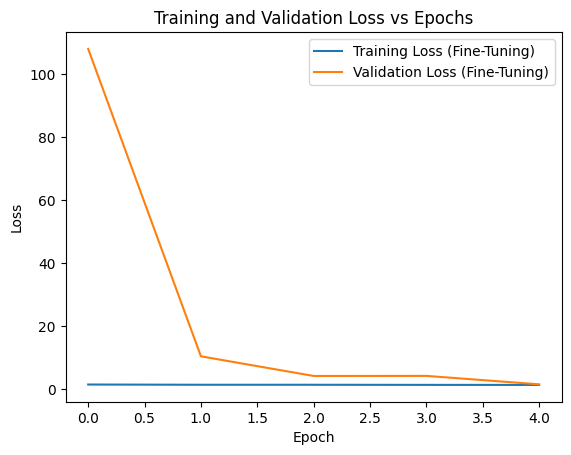

In [ ]:
# Plot training and validation loss vs epochs for Fine-Tuning
plt.plot(history_fine_tuning.history['loss'], label='Training Loss (Fine-Tuning)')
plt.plot(history_fine_tuning.history['val_loss'], label='Validation Loss (Fine-Tuning)')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss vs Epochs')
plt.show()